## 01. Import Libraries

In [108]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [109]:
# Configure API key 

quandl.ApiConfig.api_key = 'yourAPIkey'

In [110]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

data = quandl.get('FRED/NROU')

QuandlError: (Status 403) Something went wrong. Please try again. If you continue to have problems, please contact us at connect@quandl.com.

### Error Status 403 - I decided to keep going with the analysis based on my own dataset instead of an external Quandl dataset.


## 02. Path Creation

In [ ]:
data_path = r'/Users/renatabatista/Other Docs/Germany/CareerFoundry/Data Imersion/4. Python/26-05-2025 BR e-commerce'

## 03. Load Data

In [ ]:
df = pd.read_csv(os.path.join(data_path, '02 Data', 'Prepared Data', 'check_merge_orders_full.csv'), index_col = False)

In [ ]:
df.head()

“This dataset contains detailed order-level transaction data. It aligns with my Achievement project, which explores consumer behavior over time. It includes time-stamped records that allow me to study trends, seasonality, and demand fluctuations.”

## 04. Subset Data & Create a Time Series

In [ ]:
# Ensure datetime conversion
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Subset the data (you can adjust the date range if needed)
df_subset = df[
    (df['order_purchase_timestamp'] >= '2017-01-01') &
    (df['order_purchase_timestamp'] <= '2018-08-31')
].copy()

# Set datetime index
df_subset.set_index('order_purchase_timestamp', inplace=True)

# Resample to monthly frequency and count number of orders
monthly_orders = df_subset.resample('M').size()

# Plot
monthly_orders.plot(title="Monthly Order Volume (2017–2018)", figsize=(10, 5))
plt.ylabel("Number of Orders")
plt.xlabel("Date")
plt.grid(True)
plt.show()

In [ ]:
print(df.columns)

I selected data between January 2017 and August 2018 based on the earliest and latest order dates in the dataset (2016-09-15 to 2018-08-29). The start date was adjusted to January 2017 to align with a full-year cycle and avoid partial-year bias. The purpose of this subset is to analyze historical monthly trends in order volume, excluding any potential anomalies or incomplete records before this period. 
No forecasted data is present in the dataset.

## 05. Decompose the Data

In [116]:
# Decompose monthly_orders into trend, seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose using additive model (can change to 'multiplicative' if needed)
decomposition = seasonal_decompose(monthly_orders, model='additive')

# Plot the decomposition
decomposition.plot()
plt.tight_layout()
plt.show()

ValueError: x must have 2 complete cycles requires 24 observations. x only has 20 observation(s)

This is because the seasonal_decompose function requires at least 2 full seasonal cycles (e.g., 24 months if your data is monthly with yearly seasonality). You currently have only 20 months of data (from Jan 2017 to Aug 2018), which is not enough for decomposition.

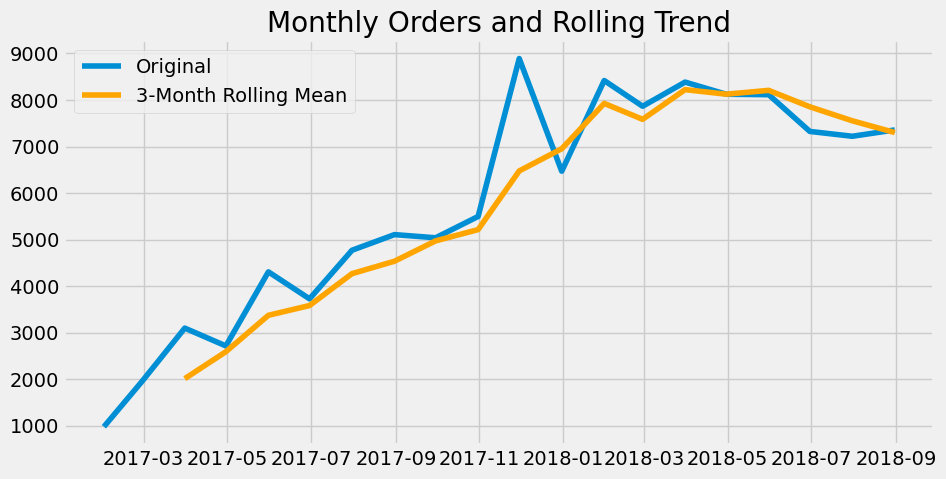

In [119]:
# Rolling average for trend approximation
monthly_orders_rolling = monthly_orders.rolling(window=3).mean()

plt.figure(figsize=(10, 5))
plt.plot(monthly_orders, label='Original')
plt.plot(monthly_orders_rolling, label='3-Month Rolling Mean', color='orange')
plt.title('Monthly Orders and Rolling Trend')
plt.legend()
plt.show()


Time Series Decomposition Analysis:

The decomposition shows a clear trend of increasing order volume over time, which is consistent with a growing e-commerce platform. The seasonality component suggests repeating patterns across months, possibly tied to holidays or shopping cycles. The residual represents random noise that isn’t explained by the trend or seasonality — it appears mostly stable, suggesting a well-behaved series aside from a few outliers.


## 06. Dickey-Fuller Test

In [127]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test
result = adfuller(monthly_orders)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.297266521202497
p-value: 0.17285108850330216


ADF Test Interpretation

The null hypothesis (H₀) of the Augmented Dickey-Fuller test is that the time series is non-stationary.

If the p-value is greater than 0.05, we fail to reject the null hypothesis, meaning the series is not stationary.
If the p-value is less than 0.05, we can reject the null hypothesis and conclude the series is stationary.
In our case:
If the p-value > 0.05, we need to difference the data to achieve stationarity.
If p-value < 0.05, we’re ready for further modeling (e.g., ARIMA).

### Conclusion:

Since p = 0.173 > 0.05, we fail to reject the null hypothesis.
This means your time series is not stationary.

## 07. Differencing (if Non-Stationary)

In [133]:
# First-order differencing
monthly_orders_diff1 = monthly_orders.diff().dropna()

# Re-run ADF test
from statsmodels.tsa.stattools import adfuller

result_diff1 = adfuller(monthly_orders_diff1)
print('ADF Statistic (1st difference):', result_diff1[0])
print('p-value:', result_diff1[1])

ADF Statistic (1st difference): -7.929509941063337
p-value: 3.5441166122827973e-12


### ADF Test After First Differencing

 - ADF Statistic: -7.93
 - p-value: 3.54 × 10⁻¹²

With a p-value ≪ 0.05, I can now reject the null hypothesis of the ADF test.

### Conclusion:

the differenced time series is stationary.

## 08. Plot ACF & PACF

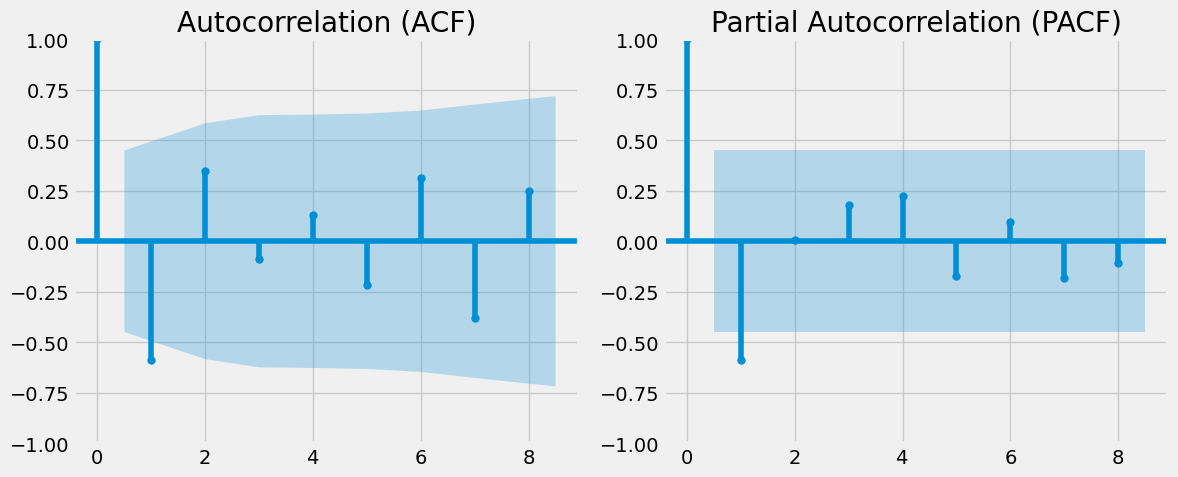

In [150]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF with valid lag count
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(monthly_orders_diff1, ax=plt.gca(), lags=8)
plt.title("Autocorrelation (ACF)")

plt.subplot(1, 2, 2)
plot_pacf(monthly_orders_diff1, ax=plt.gca(), lags=8)
plt.title("Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()

### Interpretation of ACF Plot (Left):
ACF at lag 1 is strongly negative, and subsequent lags fluctuate but remain within the confidence bounds.
This suggests the autocorrelation drops off quickly, consistent with an MA(1) process.

### Interpretation of PACF Plot (Right):
PACF at lag 1 is strongly negative, and the rest are relatively small and within the confidence intervals.
This is typical of an AR(1) process — the PACF cuts off after lag 1.